# Proyecto 1

Natalia Isabel Padilla Terrones 173716
Lorena Patricia Barrera Rodríguez 164694

## Preguntas

### 1. ¿Cuál es la variable target?

La variable target es **churn** o **no churn**, es decir que el objetivo del modelo es si el cliente abandonará la empresa o seguirá siendo cliente; por lo tanto, la etiqueta positiva es *churn*. En este caso, un *positivo verdadero* (TP) es si el modelo detecta que un cliente va a churnear y, efectivamente, churnea; un *negativo verdadero* (TN) es si el modelo detecta que un cliente no va a churnear y, efectivamente, no churnea; un *falso positivo* (FP) es si el modelo detecta que un cliente va a churnear, pero al final no lo hace; y finalmente, un *falso negativo* (FN) es si el modelo detecta que un cliente no va a churnear, pero al final sí lo hace.
Para esa situación, es preferible minimizar los falsos negativos porque son los casos que más pueden "afectar" a la empresa ya que con los FP la empresa no pierde clientes y con los FN sí. Para poder cumplir con lo dicho anteriormente, y de acuerdo al contexto del problema, la métrica que se necesita optimizar es el *recall*.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/lorenabarrera/.pyenv/versions/itam_md/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Se lee la base de datos
empresa = pd.read_csv('/Users/lorenabarrera/Documents/Minería de Datos/Telco-Customer-Churn.csv', sep=',')

In [3]:
empresa.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Limpieza de datos

In [4]:
empresa.rename(columns={'customerID': 'customer_id', 'SeniorCitizen':'senior_citizen', 
                        'Partner':'partner', 'Dependents':'dependents', 'PhoneService':'phone_service',
                        'MultipleLines':'multiple_lines', 'InternetService':'internet_service',
                        'OnlineSecurity':'online_security', 'OnlineBackup':'online_backup',
                        'DeviceProtection':'device_protection', 'TechSupport':'tech_support',
                        'StreamingTV':'streaming_tv', 'StreamingMovies':'streaming_movies',
                        'Contract':'contract', 'PaperlessBilling':'paperless_billing', 
                        'PaymentMethod':'payment_method', 'MonthlyCharges':'monthly_charges',
                        'TotalCharges':'total_charges', 'Churn':'churn'}, inplace=True)


In [5]:
empresa.customer_id.count()

7043

In [6]:
empresa.replace(' ', np.nan, inplace = True)
empresa.dropna(inplace = True)
empresa.reset_index(drop=True, inplace=True)
empresa.customer_id.count()

7032

### 2. Genera el data profiling de las variables totalcharges y la variable contract interpreta la salida.



Se analizan los datos de las columnas:

In [7]:
# Tipos de las variables
empresa.dtypes

customer_id           object
gender                object
senior_citizen         int64
partner               object
dependents            object
tenure                 int64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges         object
churn                 object
dtype: object

Ambas variables son categóricas, por lo tanto se crea una función para obtener los datos relevantes:

In [8]:
# Función para ver el data profiling
def category_profiling(df, col, profiling_dict):
    """
    Profiling for categoric columns. 
    
    :param: column to analyze
    :return: dictionary
    """
    profiling = {}

    profiling.update({'mode': df[col].mode()[0],
                     'num_categories': df[col].nunique(),
                     'categories': df[col].unique(),
                     #'uniques': df[col].nunique(),
                     'missings': sum(df[col].isna())/df[col].size*100,
                     'top1_repeated': get_repeated_values(df, col, 1),
                     'top2_repeated': get_repeated_values(df, col, 2),
                     'top3_repeated': get_repeated_values(df, col, 3)})
    
    profiling_dict.update({col: profiling})
    
    return profiling_dict

Se hace el data profiling de ambas variables:

In [9]:
def get_repeated_values(df, col, top):
    top_5 = df.groupby([col])[col]\
                    .count()\
                    .sort_values(ascending = False)\
                    .head()
    indexes_top_5 = top_5.index
    
    if ((top == 1) and (len(indexes_top_5) > 0)):
        return indexes_top_5[0]
    elif ((top == 2) and (len(indexes_top_5) > 1)):
        return indexes_top_5[1]
    elif ((top == 3) and (len(indexes_top_5) > 2)):
        return indexes_top_5[2]
    else: 
        return 'undefined'

In [10]:
profiling_category_dict = {}

In [11]:
# Data profiling de total_charges
category_profiling_output_tc = [category_profiling(empresa, "total_charges", profiling_category_dict)]
df_category_profiling = pd.DataFrame(category_profiling_output_tc[0]).reset_index()
df_category_profiling.rename(columns={'index': 'metric'}, inplace=True)

In [12]:
# Data prfiling de contract
category_profiling_output_c = [category_profiling(empresa, "contract", profiling_category_dict)]
df_category_profiling = pd.DataFrame(category_profiling_output_c[0]).reset_index()
df_category_profiling.rename(columns={'index': 'metric'}, inplace=True)

In [13]:
df_category_profiling

,metric,total_charges,contract
0,mode,20.2,Month-to-month
1,num_categories,6530,3
2,categories,"[29.85, 1889.5, 108.15, 1840.75, 151.65, 820.5...","[Month-to-month, One year, Two year]"
3,missings,0.0,0.0
4,top1_repeated,20.2,Month-to-month
5,top2_repeated,19.75,Two year
6,top3_repeated,19.65,One year


Para la variable de *cargos totales* (total_charges), podemos ver que en general lo cargos más comunes son de 20.2 pesos, seguido de cargos de 19.75 pesos y 19.65 pesos. Debido a que existen diferentes cargos para cada cliente según los servicios que tenga contratados, la infraestructura que tenga o su contrato, el número de categorías dentro de la variable es muy cambiante (6,530 diferentes opciones).

Por otro lado, para la variable de *contrato* (contract) solo hay tres posibles categorías: mes a mes, un año o dos años. De esas categorías, lo más común es que los clientes tengan el contrato de mes a mes, seguido por el contrato de dos años y por último de un año.

## 3. Genera un EDA con 4 gráficas


### Proporción de *churn* y *no churn*

In [15]:
aux=empresa.groupby("churn", as_index=False)[['monthly_charges']].count()
total=empresa['churn'].count()
aux['porcentaje']=round((aux['monthly_charges']/total)*100,2)

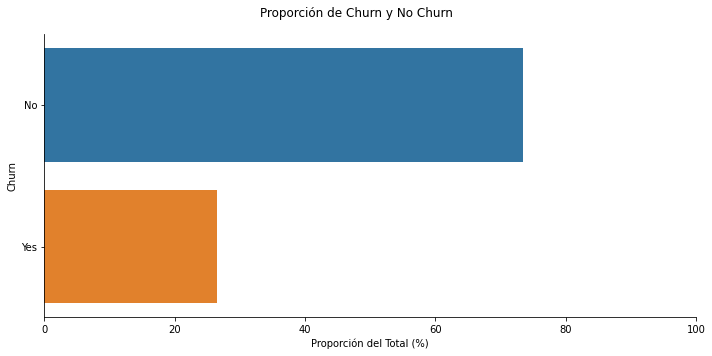

In [16]:
a=sns.catplot(x='porcentaje',y='churn', data=aux, kind='bar', orient='h', aspect=2)
a.fig.suptitle('Proporción de Churn y No Churn')
a.axes[0,0].set_xlabel('Proporción del Total (%)')
a.axes[0,0].set_ylabel('Churn')
a.set(xlim=(0,100))
plt.tight_layout()

In [17]:
churn_count = empresa.groupby(['churn']).size().reset_index(name = '# clients')
churn_count

,churn,# clients
0,No,5163
1,Yes,1869


Con esta gráfica se puede observar que menos de un tercio de los clientes de Telco dejan la empresa, es decir, hacen churn. Por lo tanto, la mayoría de los clientes están satisfechos con los servicios ofrecidos por la empresa.

### Distribución de la variable *total_charges* por contract y churn

In [ ]:
empresa.dtypes
out=empresa['total_charges'].apply(lambda col:pd.to_numeric(col, errors='coerce'))
out

In [ ]:
fig_dims=(12, 8)
fig, ax=plt.subplots(figsize=fig_dims)
sns.boxplot(data=empresa, x=out, y='contract', hue = 'churn', showmeans=True)\
.set_title("Distribución de los Total Charges por el Contract y el Churn")
plt.xlabel("Total Charges")
plt.ylabel("Contract")

<p style='text-align: justify;'> 
    Para los clientes que tienen un contrato de mes-a-mes, los cargos totales que tienen son los más bajos de los tres tipos de contratos que existen. Aunque en este subconjunto de clientes, la mayorían se queda en la empresa, es decir que no hace churn, la diferencia con el número de clientes que sí se va no es mucha. <br> <br>
    Por otro lado, los clientes que tienen un contrato de un año con la empresa tienen cargos totales más elevados que los de mes-a-mes. Dentro del subconjunto de un año, es notable que los clientes que *churnean*, muy probablemente, es debido a los cargos totales tan altos a comparación de los que no *churnean*. Al igual que los clientes de mes-a-mes, el número de clientes que se van y no se van de la empresa son muy cercanos. <br> <br>
    Finalmente, de los clientes con contratos de dos años, se puede ver que la mayoría está satisfechos con los servicios y no tienen intenciones de irse. Sin embargo, al igual que los clientes con contrato de un año, los que se van tienen cargos totales mucho más elevados que los que permanecen. <br> <br>
    Por lo tanto, si la empresa tuviera que enfocarse en sólo un subconjunto de clientes, podría ser el de un año de contrato porque *churnean* muchos clientes a comparación de los otros dos subgrupos.
</p>

### Distribución de la variable *monthly_charges* por contract y churn

Text(0, 0.5, 'Monthly Charges')

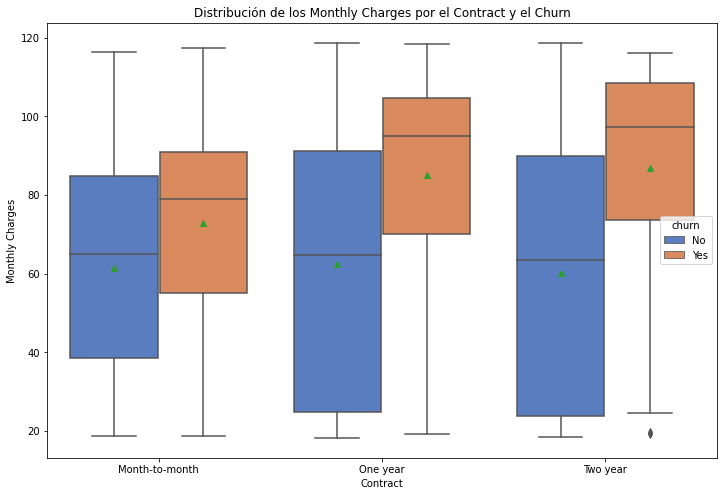

In [20]:
fig_dims=(12, 8)
fig, ax=plt.subplots(figsize=fig_dims)
sns.boxplot(data=empresa, x='contract', y='monthly_charges', hue = 'churn', showmeans=True, palette='muted')\
.set_title("Distribución de los Monthly Charges por el Contract y el Churn")
plt.xlabel("Contract")
plt.ylabel("Monthly Charges")

**INTERPRETACIÓN**

### Distribución de la variable monthlycharges por paymentmethod y churn

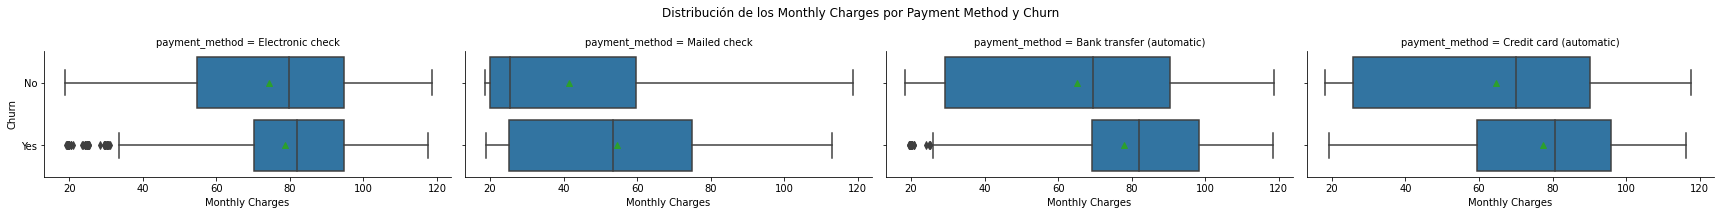

In [21]:
d=sns.FacetGrid(empresa, col='payment_method', aspect=2)
d.map_dataframe(sns.boxplot, x="monthly_charges", y="churn", showmeans=True)
d.fig.suptitle('Distribución de los Monthly Charges por Payment Method y Churn')
d.axes[0,0].set_xlabel('Monthly Charges')
d.axes[0,1].set_xlabel('Monthly Charges')
d.axes[0,2].set_xlabel('Monthly Charges')
d.axes[0,3].set_xlabel('Monthly Charges')
d.axes[0,0].set_ylabel('Churn')
plt.tight_layout()

**INTERPRETACIÓN**

## Preprocesamiento

Cambiamos las variables gender, seniorcitizen, partner, phoneservice, paperlessbilling y churn a variables binarias con valor posible 0 para el caso No y 1 para el caso Yes.

In [22]:
empresa.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [23]:
# Cambia los "Yes" a 1s y los "No" a 0s (Excepto gender en el que "Female" es 1 y "Male" es 0)
empresa["gender"].replace({"Female": 1, "Male": 0}, inplace = True)
empresa["partner"].replace({"Yes": 1, "No": 0}, inplace = True)
empresa["phone_service"].replace({"Yes": 1, "No": 0}, inplace = True)
empresa["paperless_billing"].replace({"Yes": 1, "No": 0}, inplace = True)
empresa["churn"].replace({"Yes": 1, "No": 0}, inplace = True)
empresa["dependents"].replace({"Yes": 1, "No": 0}, inplace = True)

In [24]:
empresa.groupby(['multiple_lines']).count() 

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
multiple_lines,,,,,,,,,,,,,,,,,,,,
No,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385,3385
No phone service,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680,680
Yes,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967,2967


Transformamos las variables a una codificación de one hot encoding: multiplelines, internetservice, onlinesecurity, onlinebackup, deviceprotection, techsupport, streamingtv, streamingmovies, contract, paymentmethod.

In [25]:
from sklearn.preprocessing import OneHotEncoder

In [26]:
ohe = OneHotEncoder()
ohe_df = pd.DataFrame()

In [27]:
ohe_var = ["multiple_lines", "internet_service", "online_security", "online_backup", "device_protection", 
           "tech_support", "streaming_tv", "streaming_movies", "contract", "payment_method"]

In [28]:
for i in range(len(ohe_var)):
    columna = ohe_var[i]
    ohe_ = ohe.fit_transform(empresa[columna].values.reshape(-1,1))
    df_ohe = pd.DataFrame(list(ohe_.toarray()), columns = columna + "_" + empresa[columna].unique())
    ohe_df = pd.merge(df_ohe, ohe_df, how="left", left_index = True, right_index = True)

In [29]:
ohe_df.head()

,payment_method_Electronic check,payment_method_Mailed check,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),contract_Month-to-month,contract_One year,contract_Two year,streaming_movies_No,streaming_movies_Yes,streaming_movies_No internet service,...,online_backup_No internet service,online_security_No,online_security_Yes,online_security_No internet service,internet_service_DSL,internet_service_Fiber optic,internet_service_No,multiple_lines_No phone service,multiple_lines_No,multiple_lines_Yes
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [30]:
empresa = empresa.drop(ohe_var, axis = 1)

In [31]:
empresa = pd.concat([empresa, ohe_df], axis=1)

In [32]:
empresa.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,paperless_billing,monthly_charges,total_charges,...,online_backup_No internet service,online_security_No,online_security_Yes,online_security_No internet service,internet_service_DSL,internet_service_Fiber optic,internet_service_No,multiple_lines_No phone service,multiple_lines_No,multiple_lines_Yes
0,7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.5,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Modelado

In [33]:
np.random.seed(210418)

Se generan las variables:

In [34]:
# Variable target
y = empresa.churn
y.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

In [35]:
# Variables para predecir
# Se quita la columna churn (es el target) y customer_id (causa conflicto en el árbol)
X = empresa.drop(['churn', 'customer_id'], axis = 1)
X.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,paperless_billing,monthly_charges,total_charges,payment_method_Electronic check,...,online_backup_No internet service,online_security_No,online_security_Yes,online_security_No internet service,internet_service_DSL,internet_service_Fiber optic,internet_service_No,multiple_lines_No phone service,multiple_lines_No,multiple_lines_Yes
0,1,0,1,0,1,0,1,29.85,29.85,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,0,34,1,0,56.95,1889.5,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,0,0,0,2,1,1,53.85,108.15,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,0,0,0,45,0,0,42.30,1840.75,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1,0,0,0,2,1,1,70.70,151.65,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Árbol de selección

Se hace la separación de entrenamiento

In [36]:
## separando en train, test 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## verificando los tamaños de nuestros 4 sets
print("entrenamiento: X: {}, y: {}".format(X_train.shape, y_train.shape))
print("prueba: X: {}, y: {}".format(X_test.shape, y_test.shape))

entrenamiento: X: (5274, 40), y: (5274,)
prueba: X: (1758, 40), y: (1758,)


Se configura el árbol:

In [40]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time

%matplotlib inline

grid = {'random_state': [5432], 'max_depth': [5, 7, 11], 'min_samples_leaf': [7, 9, 11, 13], 
        'criterion':['gini','entropy'] }

dt = DecisionTreeClassifier(random_state=5432)
gs_dt = GridSearchCV(dt, grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

start = time.time()
# Instanciaremos y entrenaremos el árbol con nuestros datos de entrenamiento
gs_dt.fit(X_train, y_train)
print("tiempo de ejecución en segundos: {}".format(time.time() - start))

tiempo de ejecución en segundos: 11.827330112457275


Se generan **24 modelos**, es decir que se genera un modelo por cada combinación posible entre los parámetros dados. 

Por lo tanto: 1 x 1 x 3 x 4 x 2 = 24 modelos.

In [41]:
# mejor configuración 
importancias = gs_dt.best_estimator_.feature_importances_
importancias

array([0.01146319, 0.00914269, 0.0024823 , 0.00231267, 0.15592133,
       0.00339089, 0.01192543, 0.08460734, 0.07648416, 0.00411911,
       0.        , 0.01875197, 0.00195279, 0.43681937, 0.01941309,
       0.        , 0.        , 0.        , 0.01134441, 0.00165582,
       0.        , 0.        , 0.01218505, 0.        , 0.00268436,
       0.00358144, 0.        , 0.        , 0.00976768, 0.        ,
       0.        , 0.00354587, 0.        , 0.00726961, 0.        ,
       0.09906008, 0.        , 0.00298772, 0.00288108, 0.00425054])

In [42]:
# Índices de los más importantes (están ordenados de menor a mayor)
imp_3 = np.argsort(importancias)[[-1, -2, -3, -4, -5]]
imp_3

array([13,  4, 35,  7,  8])

In [44]:
# Columnas importantes
X.columns[imp_3]

Index(['contract_Month-to-month', 'tenure', 'internet_service_Fiber optic',
       'monthly_charges', 'total_charges'],
      dtype='object')

In [45]:
# Porcentaje de importancia de las columnas importantes
importancias[imp_3]

array([0.43681937, 0.15592133, 0.09906008, 0.08460734, 0.07648416])

Las tres variables más importantes para la predicción son si no contrataron un servicio de seguridad online (online_security_No) con 30% de importancia; el total de cargos (total_charge) con 19% de importancia; y los cargos mensuales (monthly_charges) con 15% de importancia.

In [46]:
# Variables que no importan
no_imp = np.where(importancias < 0.01)
var_no_imp = X.columns[no_imp]
var_no_imp

Index(['senior_citizen', 'partner', 'dependents', 'phone_service',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'payment_method_Credit card (automatic)', 'contract_Two year',
       'streaming_movies_No', 'streaming_movies_Yes', 'streaming_tv_No',
       'streaming_tv_Yes', 'streaming_tv_No internet service',
       'tech_support_Yes', 'tech_support_No internet service',
       'device_protection_No', 'device_protection_Yes',
       'device_protection_No internet service', 'online_backup_Yes',
       'online_backup_No', 'online_backup_No internet service',
       'online_security_No', 'online_security_Yes',
       'online_security_No internet service', 'internet_service_DSL',
       'internet_service_No', 'multiple_lines_No phone service',
       'multiple_lines_No', 'multiple_lines_Yes'],
      dtype='object')

In [47]:
X_train = X_train.drop(var_no_imp, axis = 1)
X_test = X_test.drop(var_no_imp, axis = 1)

In [48]:
X_train.head()

,gender,tenure,paperless_billing,monthly_charges,total_charges,payment_method_Bank transfer (automatic),contract_Month-to-month,contract_One year,streaming_movies_No internet service,tech_support_No,internet_service_Fiber optic
5512,0,59,1,64.65,3735.45,1.0,1.0,0.0,0.0,0.0,0.0
6471,1,13,0,53.45,718.1,0.0,1.0,0.0,0.0,0.0,0.0
615,0,8,1,25.25,186.3,0.0,1.0,0.0,0.0,1.0,0.0
2521,0,1,0,19.40,19.4,0.0,1.0,0.0,0.0,0.0,0.0
571,1,11,0,64.90,697.25,0.0,0.0,1.0,1.0,0.0,0.0


No se debe volver a hacer un X_train y X_test porque la información con la que se ha trabajado se modificaría ya que se agregaría información que no debería tener y los resultados se verían sesgados.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

import matplotlib.pyplot as plt
# n_estimators corresponde al número de árboles que queremos crear: 
grid = {'random_state': [7654], 'max_depth': [11, 13, 15], 'n_estimators': [500, 800, 1000], 
        'min_samples_leaf': [11, 13], 'criterion':['gini','entropy'] }

rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
gs_rf = GridSearchCV(rf, grid, cv=5, scoring='recall', return_train_score=True, n_jobs=-1)

start = time.time()
# entrenando los random forest
gs_rf.fit(X_train, y_train)
print("tiempo de ejecución en segundos: {}".format(time.time() - start))

Se generan **36 modelos**, es decir que se genera un modelo por cada combinación posible entre los parámetros dados. 

Por lo tanto: 1 x 3 x 3 x 2 x 2 = 36 modelos.

In [ ]:
# mejor configuración 
importancias_rf = gs_rf.best_estimator_.feature_importances_
importancias_rf

In [ ]:
# Índice del más importantes (están ordenados de menor a mayor)
imp = np.argsort(importancias_rf)[[-1, -2, -3]]
imp

In [ ]:
X_train.columns[imp]

In [ ]:
importancias_rf[imp]

La variable raíz para el modelo es **tenure** con un porcentaje de 19% de información proporcionada.

Los mejores hiperparámetros para el modelo son:

In [ ]:
# mejor configuración 
gs_rf.best_estimator_

### Predicción

In [ ]:
# predicciones con el mejor predictor 
predicted_labels = gs_rf.predict(X_test)
predicted_labels[:10]

In [ ]:
# predicciones en score con el mejor predictor
predicted_scores = gs_rf.predict_proba(X_test)
predicted_scores[:10]

### ROC

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

La curva ROC está por encima del ángulo de 45ºy el AUC de nuestro modelo es de 0.67. Entonces, existe un 67% de probabilidad de que el modelo sea capaz de distinguir una muestra positiva y una muestra negativa. Por lo tanto, el modelo tiene un buen desempeño para predecir qué clientes harán *churn*.

In [ ]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)
thresholds_2 = np.append(thresholds_2, 1)
(precision.shape, recall.shape, thresholds_2.shape)

plt.clf()
plot_precision_recall_curve(gs_rf, X_test, y_test)
plt.title("Precision-recall curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

**INTERPRETACIÓN**
¿cuánto recall tienes para un precision de 70%?

In [ ]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [ ]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

¿Qué punto de corte cumple con las restricciones de negocio? A 6 decimales. Interpreta.
¿Qué porcentaje de recall tienes en ese punto? Explica.
¿Qué porcentaje de precision tienes en ese punto? Explica.

In [ ]:
negocio = metrics_report[metrics_report.fpr <= 0.02]
negocio

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predicted_labels)

El objetivo de minimizar los *falsos negativos* se logró. Es decir que de los 378 errores que tuvo el modelo, solo 114 fueron falsos negativos por lo que hizo una buena predicción.